<h2>Topic: Forcasting Champagne Sales</h2><div style="float:right;"><ul>Owner:-<li>Name: Yash Ketan Kanakia</li>
<li>Roll No: E21027</li></ul></div>

1. Problem Statement


2. Heuristic Approach
  - Naive Forecast
  - Simple Average Forecast
  - Moving Average Forecast
  - Weighted Moving Average Forecast
  
  
3. Exponential Smoothing
  - Simple Exponential Smoothing
  - Double Exponential Smoothing
  - Triple Exponential Smoothing

### Problem Statement
- We are provided with 8 years of data(Jan 1964-Sept 1972) and using this data we have to forecast the sales of Champagne.

### Dataset and Libraries

In [383]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
import warnings
warnings.filterwarnings("ignore")


# Read the Champagne dataset
df = pd.read_csv(r'C:\Users\Owner\Downloads\TF\Champagne_Sales_Forecasting\Champagne.csv',index_col ='Month',parse_dates = True)

In [384]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [385]:
df.tail()

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


#### Train and Test Split

- Creating train and test file for modeling. (January 1964 – Sep 1971) are used as training data and (Oct 1971 - Sep 1972) as testing data.

In [386]:
#Creating train and test set 
train = df.loc['1964-01-01':'1971-10-01']  #Creating a training dataset for learning
test = df.loc['1971-10-01':] #One year data for forecasting

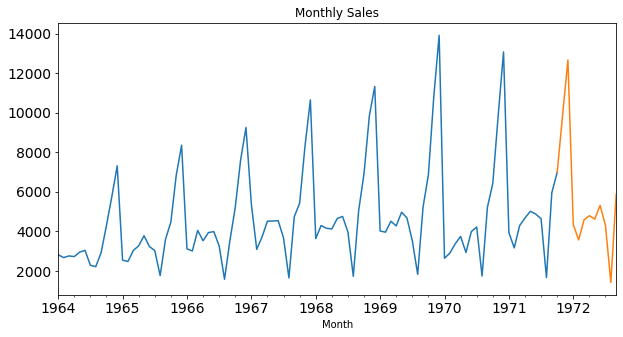

In [387]:
#Plotting data
train.Sales.plot(figsize=(10,5), title= 'Monthly Sales', fontsize=14)
test.Sales.plot(figsize=(10,5), title= 'Monthly Sales', fontsize=14)
plt.show()

## Heuristic Approach

### 1. Naive Forecast

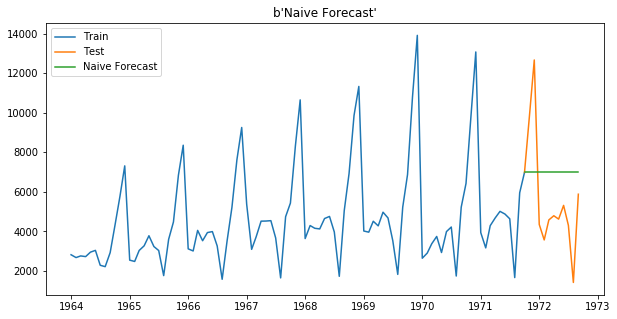

In [388]:
dd= np.asarray(train.Sales)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(10,5))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index,test['Sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title(b"Naive Forecast")
plt.show()

- Naive Method is forecasting technique which assumes that the next value's best estimate is previous value

In [389]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Sales, y_hat.naive))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  3130.3344203668294


- The value looks quite high as there is certainly some varaition in the data and Naive Forecast is best appraoch for stable data.

### 2. Simple Average Forecast

- The idea here is to understand that sometimes data varies a lot but average is usually constant over the time. Here, avarage is used to forecast the values.

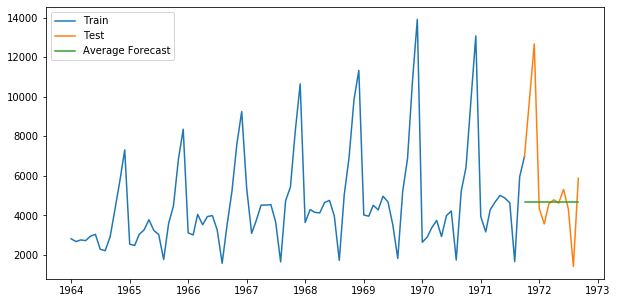

In [390]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [391]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.avg_forecast))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  3031.076695291178


- The error reduced as compared to Naive but not to a great extent.

### 3. Moving Average Forecast

- The Average probably did not improve the rmse as there an increase in sales over each year which means average must be increasing too. Here, we need to take average of per year to forecast.

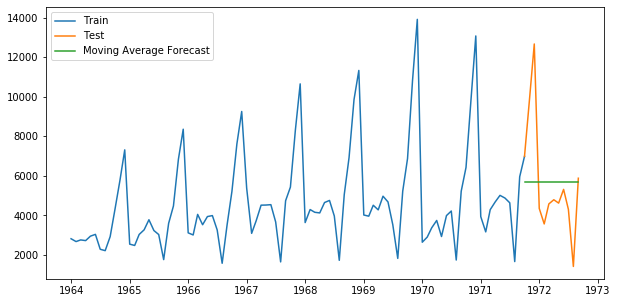

In [392]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Sales'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [393]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
print("Root Mean Square Error: ",rms)

Root Mean Square Error:  2852.4171280200626


- The value reduced certainly compared to naive and simple avg but we are still not sure if this is the final model.

### Weighted Moving Average Forecast

- As we could infer from the moving average that average sales of each year is different rather it is increasing. So, we could try giving more importance to recent years and try to forecast the sales.

In [394]:
#Creating train and test set 
train = df.loc['1964-01-01':'1970-10-01']
test = df.loc['1970-10-01':]
print(len(test))

24


In [395]:
#Weights to be given to years. Eg:- 12 to most recent, 11 to next most recent and so on...
weights = np.arange(1,13)
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [396]:
#Calculating Weighted Moving Average
y_hat = test.copy()
y_hat['wma_sales'] = test['Sales'].rolling(12).apply(lambda sales: np.dot(sales, weights)/weights.sum(), raw=True)

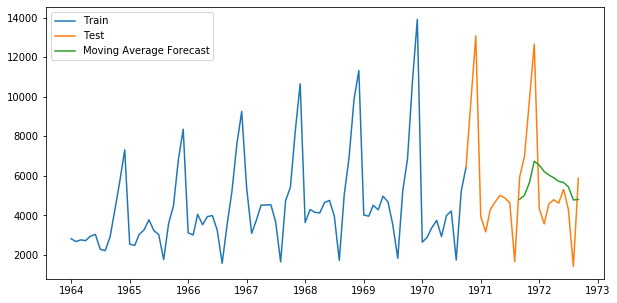

In [397]:
plt.figure(figsize=(10,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat['wma_sales'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [398]:
y_actual= test[test.index > '1971-09-01']
y_hat= y_hat[y_hat.index > '1971-09-01']

In [399]:
rms = sqrt(mean_squared_error(y_actual.Sales, y_hat.wma_sales))
print(rms)

2690.728787338142


- Giving more importance to the last 12 years in forecasting reduced the RMSE considerably but not quite accurate in capturing the fluctuation in the sales.

## Exponential Smoothing

- Exponential smoothing, is used to weight data from previous time periods with exponentially decreasing importance in the forecast.

- If a is chosen to be less than .5, less weight is placed on the actual value than on the forecast of that value. If a is chosen to be greater than .5, more weight is being put on the actual value than on the forecast value.

- An exponential smoothing of time series data allocates the exponentially decaying weights

In [400]:
train = df.loc['1964-01-01':'1971-10-01']
test = df.loc['1971-10-01':] 

### 1. Simple Exponential Smoothing

- Single exponential smoothing only estimates the level component. Level is also called base.

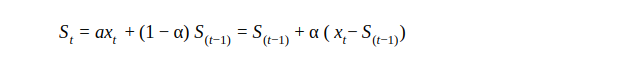

In [401]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

alpha_list = [0.2,0.5,0.8]
alpha_mse_values = {}
for i in alpha_list:

    fit2 = SimpleExpSmoothing(np.asarray(train['Sales'])).fit(smoothing_level=i,optimized=False)
    y_hat_avg['SES'] = fit2.forecast(len(test))

    rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
    alpha_mse_values[i] = rms

In [402]:
RMSE = min(alpha_mse_values.values())
best_alpha = [key for key in alpha_mse_values if alpha_mse_values[key] == RMSE]

print("The lowest RMSE :",RMSE," at alpha: ",best_alpha)

The lowest RMSE : 2853.7104279652585  at alpha:  [0.5]


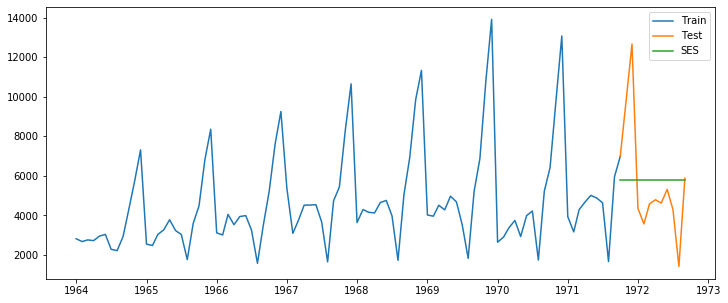

In [403]:
fit2 = SimpleExpSmoothing(np.asarray(train['Sales'])).fit(smoothing_level=0.5,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))

plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

- Giving equal importance to the actual values and forecasted values has reduced the RMSE to great extent but it is still not accurate in capturing the fluctuation in the sales.

#### Need to address the trend and seasonality too

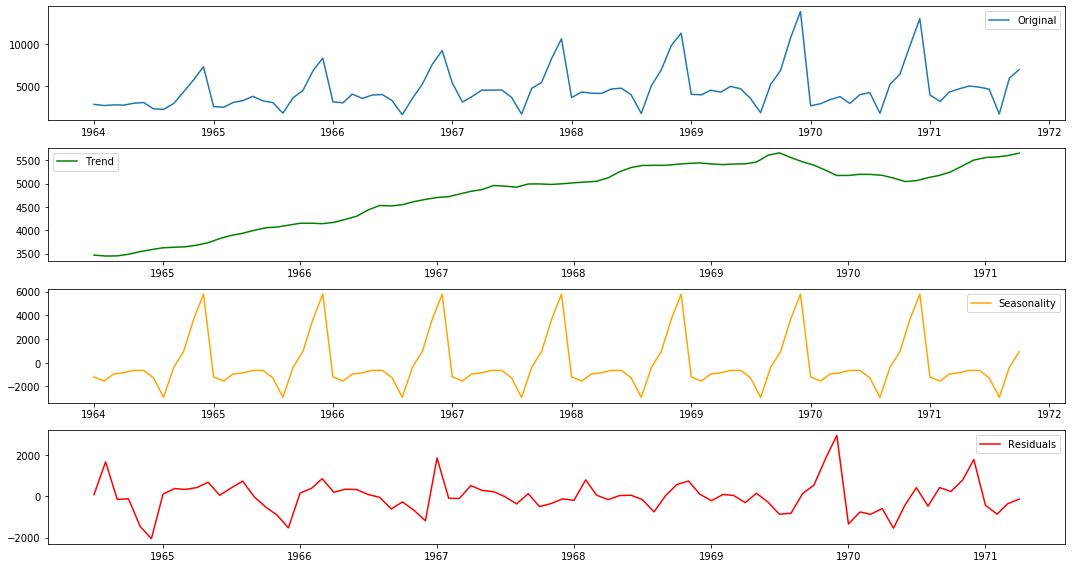

In [404]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15,8))
res = seasonal_decompose(train.Sales,model='additive')
trend = res.trend
seasonal = res.seasonal
residual = res.resid

plt.subplot(411)
plt.plot(train.Sales, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend',color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='orange')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals',color='red')
plt.legend(loc='best')
plt.tight_layout()

### Double Exponential as it has Trend

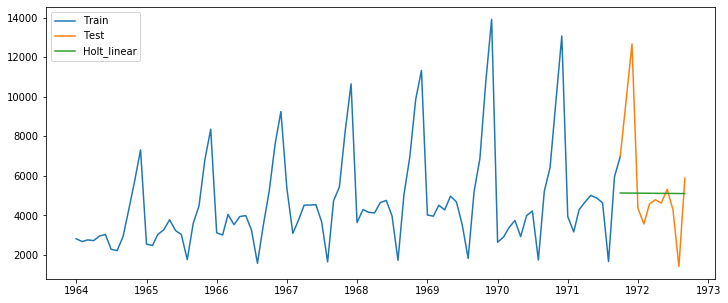

In [436]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Sales'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(12,5))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [437]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_linear))
print(rms)

2905.0332337664513


### Triple Exponential as it has Trend and Seasonality

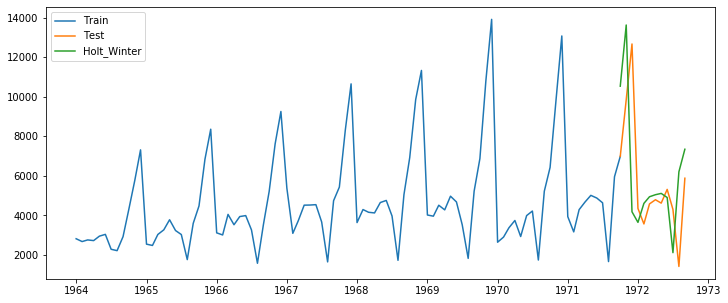

In [407]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(12,5))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [408]:
rms = sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_Winter))
print(rms)

3304.760140625756
